In [2]:
!pip install torchsummary

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torchvision.datasets.utils import download_file_from_google_drive
from torch import optim, cuda
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchsummary import summary
import seaborn as sns
import torch.nn as nn
import torch
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import pandas as pd
import warnings
import random
warnings.filterwarnings('ignore', category=FutureWarning)
from PIL import Image

In [12]:
file_id = "1oWsyaInJI8MJl0XA6NjeuFlPP9MBD49S"
root = "/kaggle/working"
file_name = "vgg_cur_model_transfer_learning_2.pt"
download_file_from_google_drive(file_id, root, file_name)

In [13]:
index_to_char_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'}

In [14]:
image_transforms = transforms.Compose([
                        transforms.Resize((224, 224)),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])

In [15]:
#Parameters
dataset_1_dir = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train' #Link: https://www.kaggle.com/grassknoted/asl-alphabet
dataset_2_dir = '../input/asl-alphabet-new-test/asl-alphabet-test' #Link: https://www.kaggle.com/yashudaykulkarni/asl-alphabet-new-test

img_dir = '../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/'

save_file_name = '/kaggle/working/vgg_cur_model_transfer_learning_2.pt'

batch_size = 16
lr = 0.001
momentum = 0.9
epoch_stop_condition = 5
n_epochs = 5

dataset_1_length = 87000
dataset_2_length = 870

n_classes = 29

train_split_ratio = 0.5
val_split_ratio = 0.25

In [16]:
def load_model(model):
    device = torch.device('cpu')
    model.load_state_dict(torch.load(save_file_name, map_location=device))
    model.optimizer = optimizer

In [17]:
def get_predictions(img, model):

    probs = nn.Softmax(dim=1)
    
    img = img.unsqueeze(0)
    
    top5_classes = []
    
    with torch.no_grad():
        model.eval()

        output = model(img)
        softmax_output = probs(output)   
        
        top5_probs, top5_label = torch.topk(softmax_output, 5)
        
        top5_probs_list = top5_probs.cpu().flatten().tolist()
        top5_label_list = top5_label.cpu().flatten().tolist()
        
        for elem in top5_label_list:
            top5_classes.append(index_to_char_map[elem])
            
        return top5_probs_list, top5_classes

In [18]:
def get_random_classes(count):
    random_classes_list = []
    
    random_classes_list = random.sample(range(29), 5)
    
    return random_classes_list

In [28]:
def get_model(pretrained):
    if pretrained:
        model = models.vgg16_bn(pretrained=True)
    else:
        model = models.vgg16_bn()
    model.classifier = nn.Sequential(nn.Linear(in_features=25088, out_features=4096, bias=True),
                                     nn.ReLU(inplace=True),
                                     nn.Dropout(p=0.5, inplace=False),
                                     nn.Linear(in_features=4096, out_features=4096, bias=True),
                                     nn.ReLU(inplace=True),
                                     nn.Dropout(p=0.5, inplace=False),
                                     nn.Linear(in_features=4096, out_features=29, bias=True)
                                    )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    return model, criterion, optimizer

In [29]:
model, criterion, optimizer = get_model(False)

In [30]:
load_model(model)

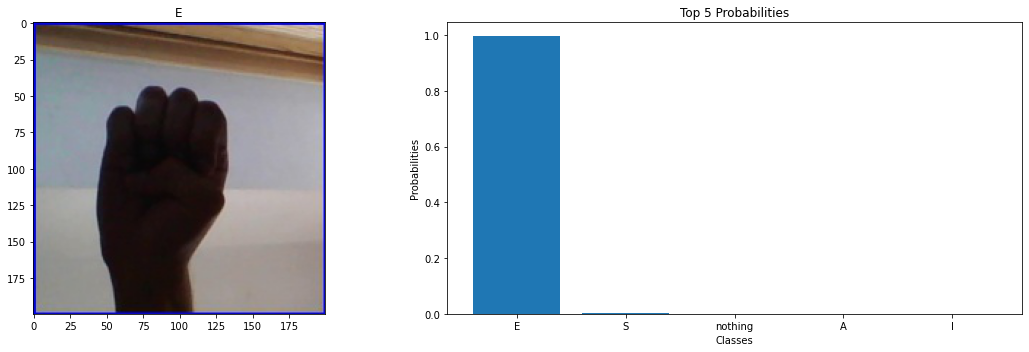

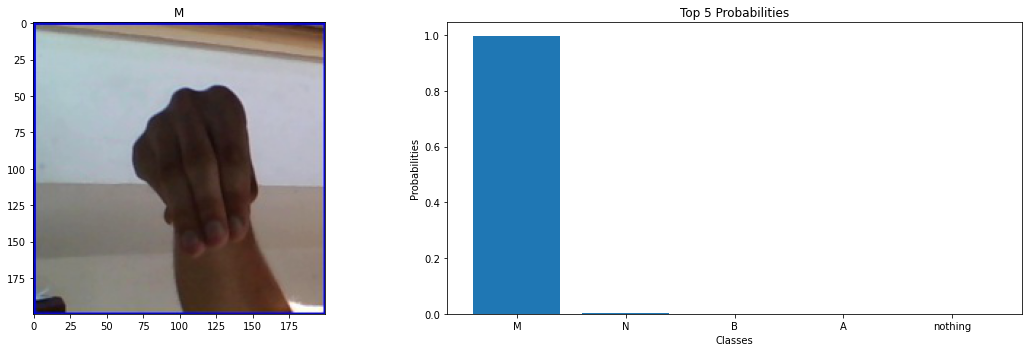

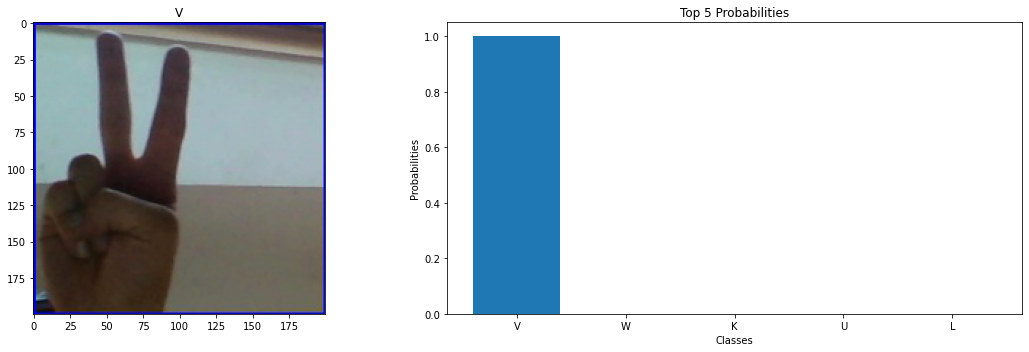

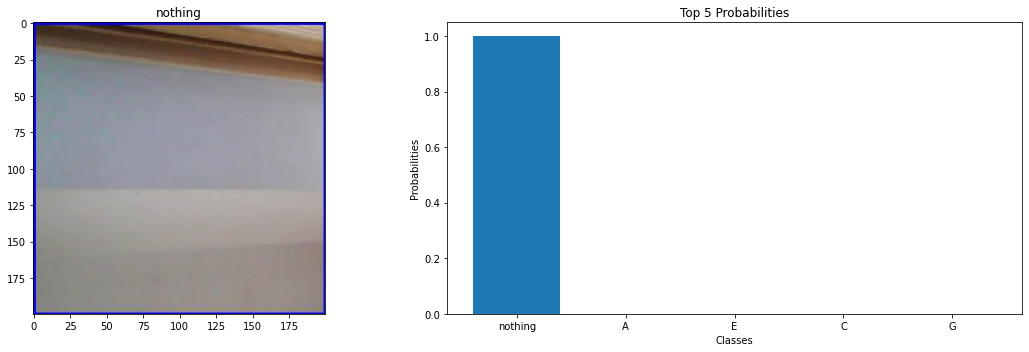

In [31]:
random_class_list = get_random_classes(5)

for value in random_class_list:
    value = index_to_char_map[value]
    if value != 'del':
        img = Image.open(img_dir + value + '_test.jpg')
        transformed_img = image_transforms(img)
        top5_prob, top5_label = get_predictions(transformed_img, model)
        
        plt.figure(figsize=(16, 5))
        
        ax = plt.subplot(1, 2, 1)
        ax.imshow(img)
        ax.set_title(value)
        
        ax = plt.subplot(1, 2, 2)
        ax.bar(top5_label, top5_prob)
        ax.set_title('Top 5 Probabilities')
        ax.set_xlabel('Classes')
        ax.set_ylabel('Probabilities')
        
        plt.tight_layout()
        
        plt.savefig(value + '_graph.png')